In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [6]:
# Load data
file_path = "../Desktop/SMU Mental Health Week 2023.xlsx"
df = pd.read_excel(file_path, sheet_name=0)
df.columns = [c.strip() for c in df.columns]

In [7]:
# Identify Likert columns
likert_cols = [c for c in df.columns if "." in c and any(x in c for x in [
    "I found the activity engaging", 
    "I can apply the learning gleaned from this activity",
    "I will recommend this activity to others"
])]

likert_map = {
    "Strongly agree": 5,
    "Agree": 4,
    "Neutral": 3,
    "Disagree": 2,
    "Strongly disagree": 1,
}



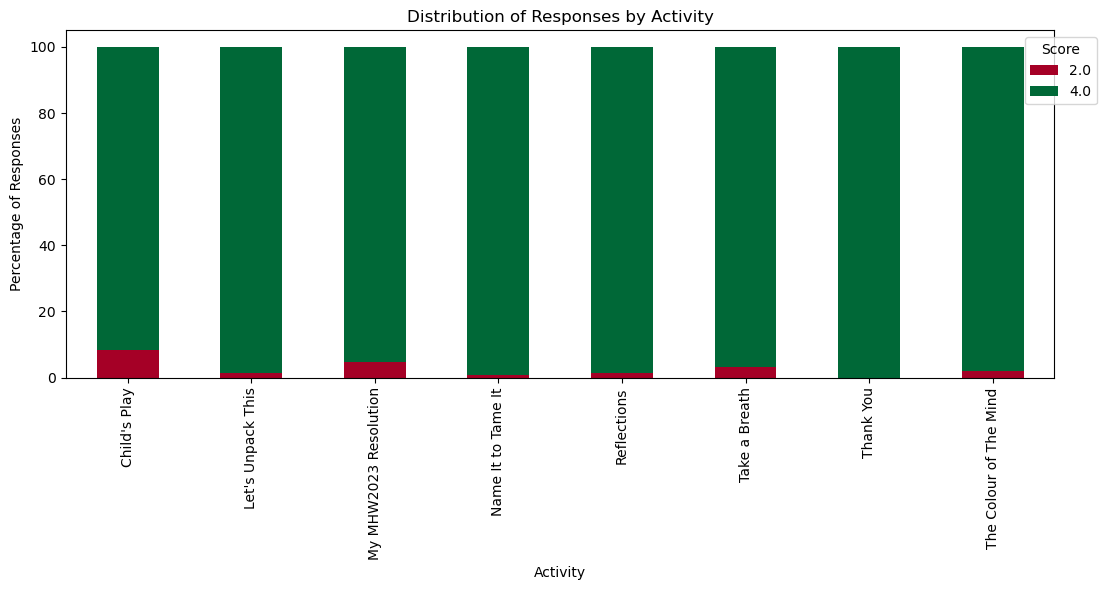

Engagement Index Summary:
count    215.000000
mean      78.376138
std        5.315579
min       40.000000
25%       80.000000
50%       80.000000
75%       80.000000
max       80.000000
Name: EngagementIndex, dtype: float64

Top 5 Engaged Students:
         Full Name  EngagementIndex
1              Som             80.0
193  Yong Jia Ying             80.0
196     Ho Ka Tung             80.0
197   Serena Chua              80.0
201  Wong Shi Chin             80.0

Bottom 5 Engaged Students:
               Full Name  EngagementIndex
279         Siah Bing Qi             40.0
190           Li Yunling             40.0
282           Aldous Koh             56.0
322         Nonie Thebez             60.0
209  Ashlyn Yip Zhi Qing             60.0


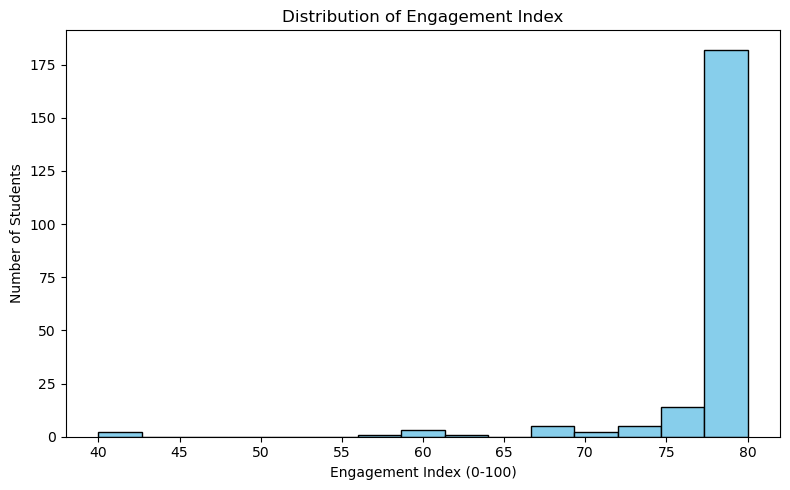


Cluster Mean Scores (sample):
Activity                                        Child's Play  \
Question I can apply the learning gleaned from this activity   
Cluster                                                        
0                                                  3.813953    
1                                                  2.000000    
2                                                  3.000000    

Activity                                \
Question I found the activity engaging   
Cluster                                  
0                             3.928571   
1                             2.000000   
2                             4.000000   

Activity                                           \
Question I will recommend this activity to others   
Cluster                                             
0                                        3.819672   
1                                        2.000000   
2                                        4.000000   

Activity    

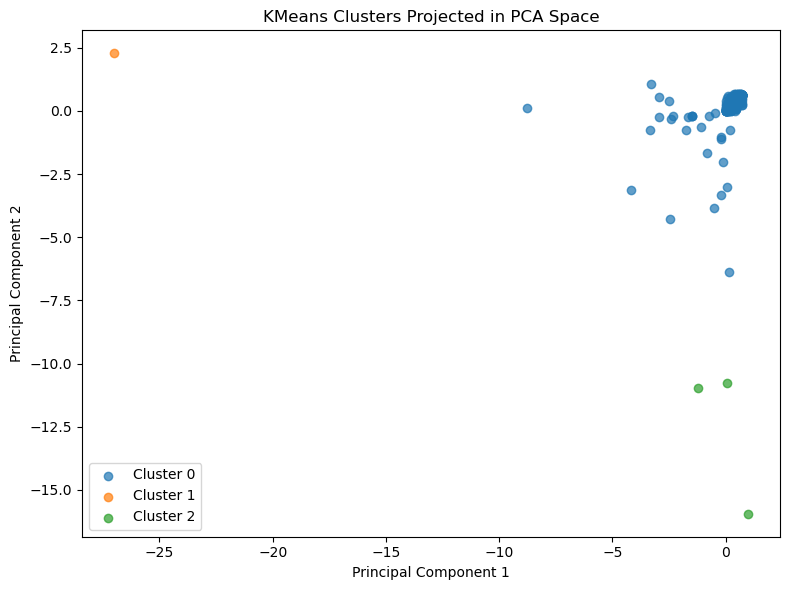


Interpretation:
- Clusters group students with similar response patterns.
- If PCA shows tight clumping, students responded similarly (low diversity).
- If clusters separate clearly, it shows distinct respondent groups (e.g., highly engaged vs neutral).
- Engagement Index gives a simple metric per student, making it easy to spot outliers or very engaged individuals.



In [24]:
def map_likert(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().title()
    s = s.replace("Stongly", "Strongly")
    return likert_map.get(s, np.nan)

df_scored = df.copy()
for c in likert_cols:
    df_scored[c] = df_scored[c].apply(map_likert)

def split_activity_question(col):
    parts = col.split(".", 1)
    return parts[0].strip(), parts[1].strip()

# Long format
rows = []
for c in likert_cols:
    a, q = split_activity_question(c)
    for idx, val in df_scored[c].items():
        rows.append({"Id": df_scored.loc[idx, "Id"], "Activity": a, "Question": q, "Score": val})
tidy = pd.DataFrame(rows)

# ----- 1. Stacked Likert Bar Chart -----
# Count responses by Activity and Score
likert_counts = tidy.groupby(["Activity", "Score"]).size().unstack(fill_value=0)

# Convert to percentages
likert_perc = likert_counts.div(likert_counts.sum(axis=1), axis=0) * 100

# Plot stacked bar chart
ax = likert_perc.plot(kind="bar", stacked=True, figsize=(12,6), colormap="RdYlGn")
plt.title("Distribution of Responses by Activity")
plt.ylabel("Percentage of Responses")
plt.xlabel("Activity")
plt.legend(title="Score", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# ----- 2. Engagement Index -----
# Weighted sum: Strongly Agree (5) has more weight
# Normalize index to 0–100
engagement_index = tidy.groupby("Id")["Score"].mean() * 20
df_scored["EngagementIndex"] = df_scored["Id"].map(engagement_index)

print("Engagement Index Summary:")
print(df_scored["EngagementIndex"].describe())

# Top 5 and Bottom 5 Engaged Students
print("\nTop 5 Engaged Students:")
print(df_scored[["Full Name", "EngagementIndex"]].sort_values(by="EngagementIndex", ascending=False).head())

print("\nBottom 5 Engaged Students:")
print(df_scored[["Full Name", "EngagementIndex"]].sort_values(by="EngagementIndex").head())

# Histogram of Engagement Index
plt.figure(figsize=(8,5))
plt.hist(df_scored["EngagementIndex"].dropna(), bins=15, color="skyblue", edgecolor="black")
plt.title("Distribution of Engagement Index")
plt.xlabel("Engagement Index (0-100)")
plt.ylabel("Number of Students")
plt.tight_layout()
plt.show()

# ----- 3. Interpret KMeans Clusters -----
# Get cluster-level averages
clustered = tidy.pivot_table(index="Id", columns=["Activity","Question"], values="Score")
clustered["Cluster"] = labels  # 'labels' from your KMeans block
cluster_means = clustered.groupby("Cluster").mean()

print("\nCluster Mean Scores (sample):")
print(cluster_means.head())

# Summarize cluster size
unique, counts = np.unique(labels, return_counts=True)
print("\nCluster Sizes:")
for u, c in zip(unique, counts):
    print(f"Cluster {u}: {c} students")

# PCA explained variance
print("\nPCA Explained Variance (Top 2 PCs):")
print(pca.explained_variance_ratio_)

# Plot PCA with cluster colors
plt.figure(figsize=(8,6))
for cl in np.unique(labels):
    idx = labels == cl
    plt.scatter(X_pca[idx,0], X_pca[idx,1], label=f"Cluster {cl}", alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("KMeans Clusters Projected in PCA Space")
plt.legend()
plt.tight_layout()
plt.show()

# ----- 4. Interpretation Helper -----
print("""
Interpretation:
- Clusters group students with similar response patterns.
- If PCA shows tight clumping, students responded similarly (low diversity).
- If clusters separate clearly, it shows distinct respondent groups (e.g., highly engaged vs neutral).
- Engagement Index gives a simple metric per student, making it easy to spot outliers or very engaged individuals.
""")


# Faculty/year extraction
def extract_faculty(email):
    try:
        domain = email.split("@",1)[1]
        sub = domain.split(".")[0].lower()
    except Exception:
        return "Unknown"
    mapping = {
        "scis": "SCIS", "sis": "SCIS",
        "business": "LKCSB",
        "accountancy": "SOA",
        "economics": "SOE",
        "socsc": "SOSS",
        "socialsciences": "SOSS",
        "law": "SOL"
    }
    return mapping.get(sub, "Unknown")

def extract_entry_year(local_part):
    match = re.search(r"(20\d{2})", local_part)
    return int(match.group(1)) if match else None

def derive_year_of_study(email, current_year=2025):
    try:
        entry = extract_entry_year(email.split("@",1)[0])
        if entry and 2015 <= entry <= current_year:
            yos = (current_year - entry) + 1
            return min(max(yos,1),6)
        return np.nan
    except:
        return np.nan

engagement index
Each bar = number of students whose Engagement Index falls within that range.

Engagement Index is a 0–100 scale:

100 ≈ all answers were “Strongly Agree” (5/5).

80 ≈ all answers were “Agree” (4/5).

60 ≈ mostly “Neutral” (3/5).

40 ≈ mostly “Disagree” (2/5).

The huge spike near 80 shows that most students rated everything positively (Agree).

In [9]:
df_scored["Faculty"] = df_scored["SMU Email Address"].apply(extract_faculty)
df_scored["YearOfStudy"] = df_scored["SMU Email Address"].apply(derive_year_of_study)

# Respondent-level scores
respondent_scores = tidy.groupby("Id")["Score"].agg(TotalScore="sum", MeanScore="mean").reset_index()
df_scored = df_scored.merge(respondent_scores, on="Id", how="left")

# Activity summary
activity_summary = tidy.groupby(["Activity", "Question"])["Score"].mean().reset_index().pivot(index="Activity", columns="Question", values="Score")
activity_summary["Overall (mean of 3)"] = activity_summary.mean(axis=1)

print("Activity Summary:\n", activity_summary.head())


Activity Summary:
 Question               I can apply the learning gleaned from this activity  \
Activity                                                                     
Child's Play                                                    3.787879     
Let's Unpack This                                               3.958333     
My MHW2023 Resolution                                           3.890411     
Name It to Tame It                                              3.984127     
Reflections                                                     3.968504     

Question               I found the activity engaging  \
Activity                                               
Child's Play                                3.913043   
Let's Unpack This                           3.978495   
My MHW2023 Resolution                       3.909774   
Name It to Tame It                          3.984252   
Reflections                                 3.967480   

Question               I will recommend t

In [10]:
# Faculty & Year summaries
faculty_summary = tidy.join(df_scored.set_index("Id")[["Faculty"]], on="Id").groupby(["Faculty", "Activity"])["Score"].mean().reset_index()
year_summary = tidy.join(df_scored.set_index("Id")[["YearOfStudy"]], on="Id").groupby(["YearOfStudy", "Activity"])["Score"].mean().reset_index()

print("\nFaculty Summary:\n", faculty_summary.head())
print("\nYear Summary:\n", year_summary.head())



Faculty Summary:
   Faculty               Activity     Score
0   LKCSB           Child's Play  3.925926
1   LKCSB      Let's Unpack This  4.000000
2   LKCSB  My MHW2023 Resolution  3.862069
3   LKCSB     Name It to Tame It  3.956522
4   LKCSB            Reflections  3.959184

Year Summary:
    YearOfStudy               Activity     Score
0          3.0           Child's Play  3.893805
1          3.0      Let's Unpack This  3.979381
2          3.0  My MHW2023 Resolution  3.897436
3          3.0     Name It to Tame It  3.982143
4          3.0            Reflections  4.000000


In [12]:
# Save cleaned data
df_scored.to_csv("../Desktop/SMU_MHW2023_cleaned_scored.csv", index=False)

In [13]:
# Clustering
wide = tidy.pivot_table(index="Id", columns=["Activity","Question"], values="Score", aggfunc="mean")
col_means = wide.mean(axis=0)
X_imputed = wide.fillna(col_means)
X_scaled = StandardScaler().fit_transform(X_imputed)

k = 3
labels = KMeans(n_clusters=k, n_init=10, random_state=42).fit_predict(X_scaled)
clustered = pd.DataFrame({"Id": wide.index, "Cluster": labels})
print("\nCluster Sizes:\n", clustered["Cluster"].value_counts())


Cluster Sizes:
 Cluster
0    211
2      3
1      1
Name: count, dtype: int64


In [14]:
# Topic modeling
text_cols = [
    "Please share with us key takeaways from Mental Health Week 2023",
    "Please let us know how we can improve Mental Health Week for the SMU community",
    "Any other feedback or comments"
]
text_series = df_scored[text_cols].astype(str).apply(lambda s: s.str.strip()).replace({"nan": ""})
combined_text = text_series.apply(lambda r: " . ".join([x for x in r if x]), axis=1)
combined_text = combined_text[combined_text.str.len()>0]

vectorizer = CountVectorizer(stop_words="english", max_df=0.85, min_df=5)
X_text = vectorizer.fit_transform(combined_text)
n_topics = 5 if X_text.shape[0] >= 10 else max(1, min(3, X_text.shape[0]))
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(X_text)

terms = np.array(vectorizer.get_feature_names_out())
for topic_idx, comp in enumerate(lda.components_):
    top_idx = comp.argsort()[-12:][::-1]
    print(f"\nTopic {topic_idx} top words:", ", ".join(terms[top_idx]))


Topic 0 top words: good, learnt, time, fun, emotions, event, feel, positive, things, life, need, negative

Topic 1 top words: nil, calm, self, awareness, learn, aware, ways, change, feelings, learned, think, ground

Topic 2 top words: great, techniques, break, grounding, food, time, free, life, good, relax, maybe, thanks

Topic 3 top words: activities, na, really, emotions, better, engaging, enjoyed, step, fun, games, nice, important

Topic 4 top words: mental, health, important, care, thank, self, think, activity, love, good, wellness, booths


- cleaned & scored likert data
- extracted faculty/year
- summarised activities, faculty, year 
- ran clustering (k means)
- did topic modelling (LDA)

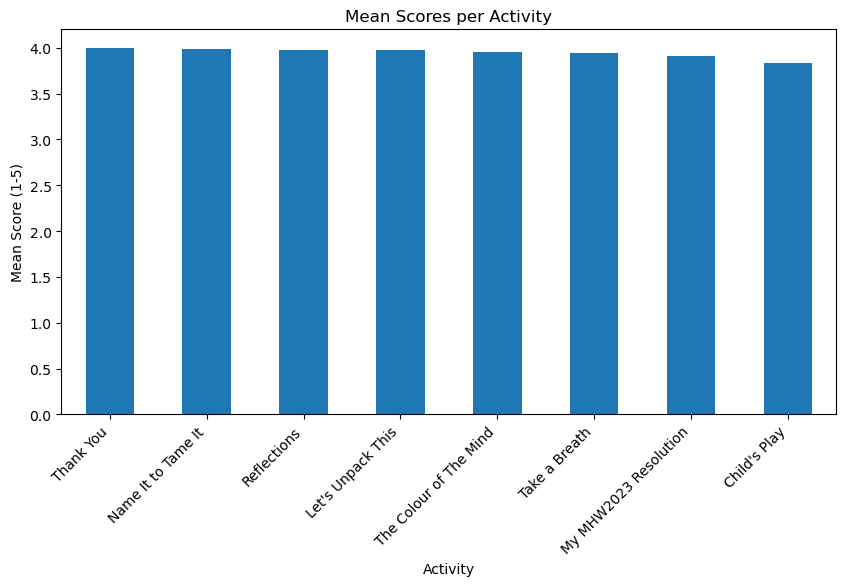

In [ ]:
# Acitivity comparison 
activity_summary_sorted = activity_summary.sort_values("Overall (mean of 3)", ascending=False)
activity_summary_sorted["Overall (mean of 3)"].plot(kind='bar', figsize=(10,5), title="Mean Scores per Activity")
plt.ylabel("Mean Score (1-5)")
plt.xticks(rotation=45, ha="right")
plt.show()


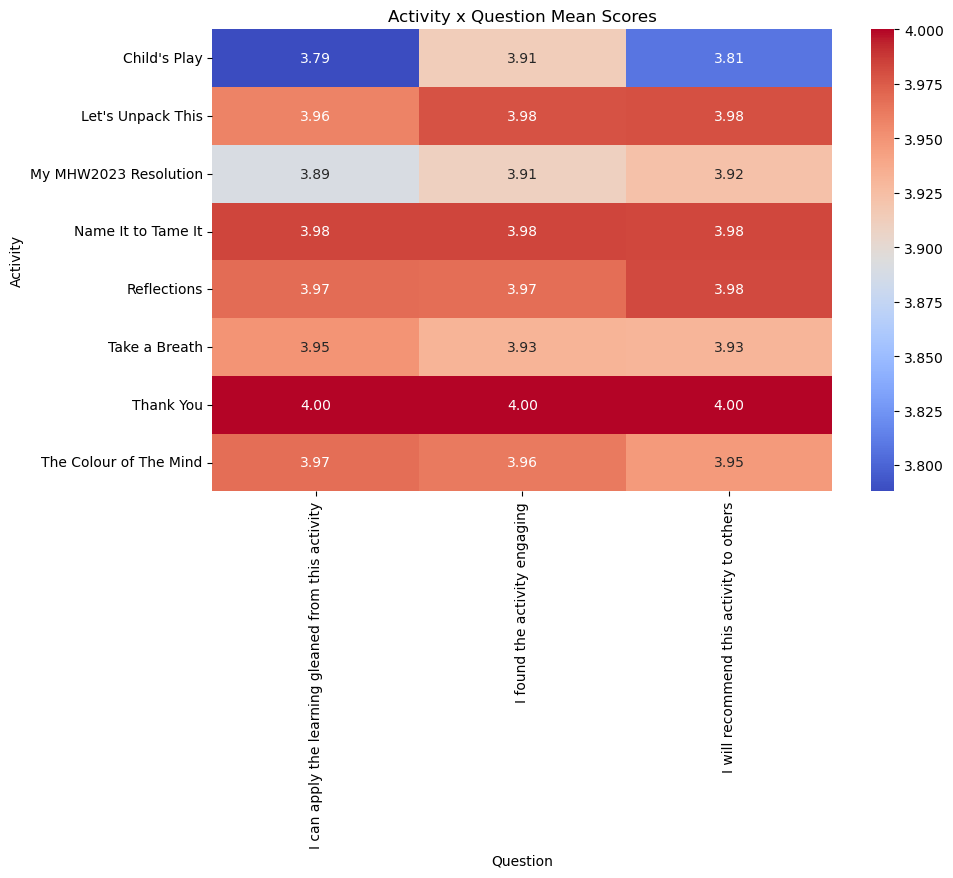

In [17]:
# heatmap question vs activity 
# see which questions drag scores down
import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(activity_summary.drop(columns=["Overall (mean of 3)"]), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Activity x Question Mean Scores")
plt.show()

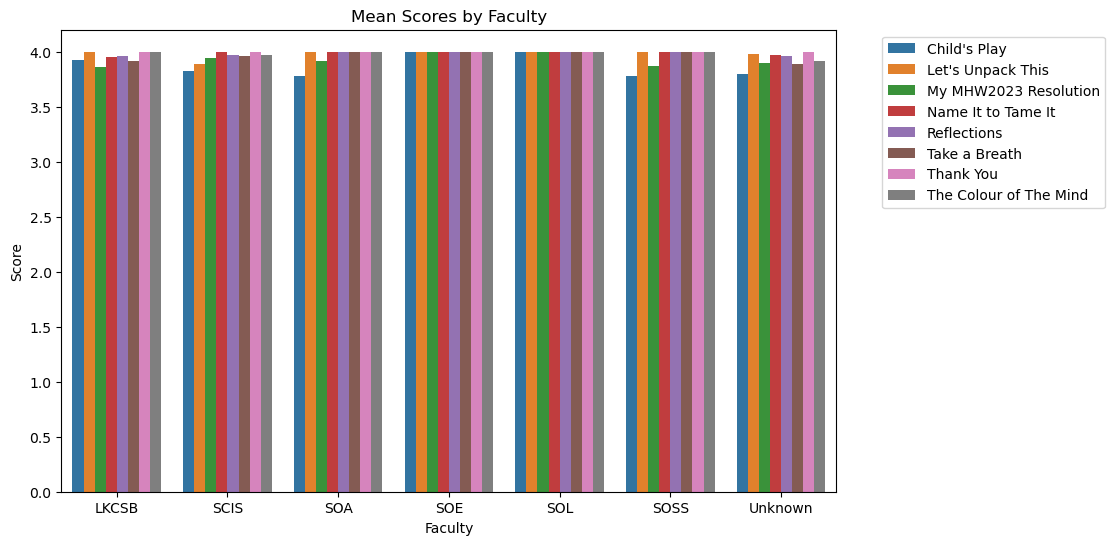

In [18]:
# faculty/year trends
plt.figure(figsize=(10,6))
sns.barplot(data=faculty_summary, x="Faculty", y="Score", hue="Activity")
plt.title("Mean Scores by Faculty")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.show()


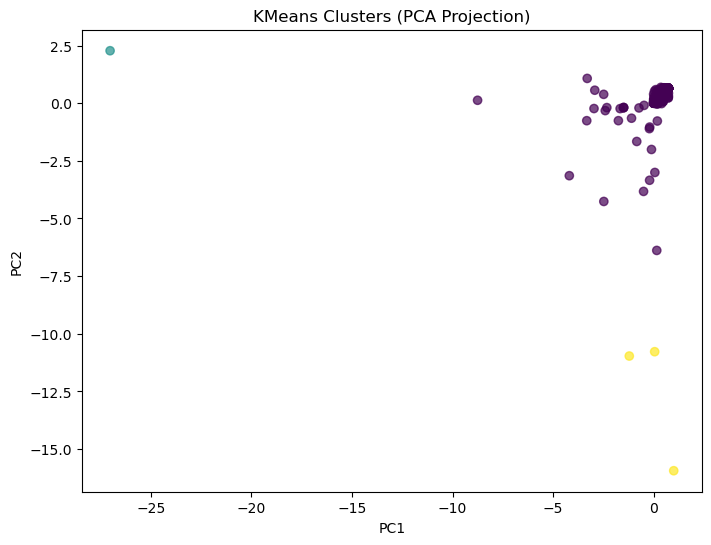

In [19]:
# right now i have 3 clusters, and they are imbalanced 
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap="viridis", alpha=0.7)
plt.title("KMeans Clusters (PCA Projection)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()


In [20]:
# checking cluster profiles
cluster_means = wide.copy()
cluster_means["Cluster"] = labels
print(cluster_means.groupby("Cluster").mean())


Activity                                        Child's Play  \
Question I can apply the learning gleaned from this activity   
Cluster                                                        
0                                                  3.813953    
1                                                  2.000000    
2                                                  3.000000    

Activity                                \
Question I found the activity engaging   
Cluster                                  
0                             3.928571   
1                             2.000000   
2                             4.000000   

Activity                                           \
Question I will recommend this activity to others   
Cluster                                             
0                                        3.819672   
1                                        2.000000   
2                                        4.000000   

Activity                                   

In [ ]:
# summarise open ended topics
# using lda.components and terms 
for topic_idx, comp in enumerate(lda.components_):
    top_idx = comp.argsort()[-10:][::-1]
    print(f"Topic {topic_idx}: {', '.join(terms[top_idx])}")


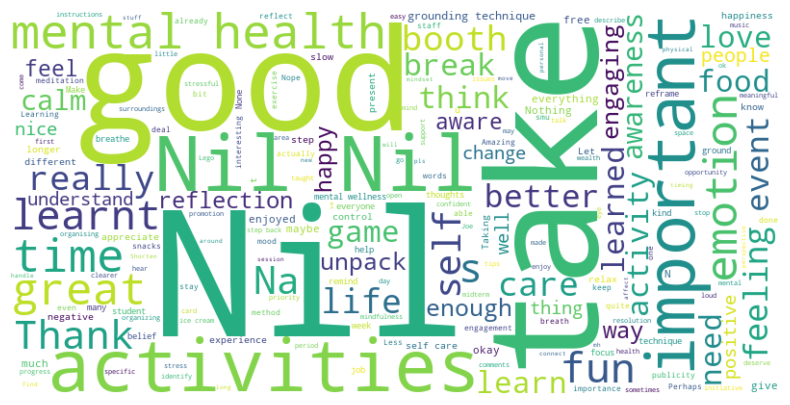

In [22]:
# make a word cloud
from wordcloud import WordCloud
all_text = " ".join(combined_text)
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
